# Usage with Python

Seperately using Python and Julia is covered in IntrinsicTimescales.jl [documentation](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/tutorial/tutorial_2_mne/). Here, we'll cover using Julia and IntrinsicTimescales.jl directly inside Python.

The Python package [JuliaCall](https://juliapy.github.io/PythonCall.jl/stable/juliacall/) lets us use Julia inside Python. Install it into your Python environment (where you also have MNE) as 

```
pip install juliacall
```

Let's import JuliaCall inside Python and test it. 

In [1]:
from juliacall import Main as jl
jl.println("Hello from Julia!")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Hello from Julia!


Let's import `IntrinsicTimescales.jl` in our JuliaCall module. 

In [2]:
from juliacall import Pkg as jlPkg
jlPkg.activate(r"C:\Users\yasir\Desktop\brain_stuff\workshop2025")
jl.seval("using IntrinsicTimescales") # Evaluate the string: seval

  Activating project at `C:\Users\yasir\Desktop\brain_stuff\workshop2025`


Now let's load the example resting state dataset from MNE. Details of the dataset are described in [here](https://mne.tools/stable/documentation/datasets.html#resting-state). 

In [3]:
import mne
import os.path as op
import numpy as np

# Download example data and specify the path
data_path = mne.datasets.brainstorm.bst_resting.data_path()
raw_fname = op.join(data_path, "MEG", "bst_resting", "subj002_spontaneous_20111102_01_AUX.ds")

# Read data
raw = mne.io.read_raw_ctf(raw_fname)

ds directory : C:\Users\yasir\mne_data\MNE-brainstorm-data\bst_resting\MEG\bst_resting\subj002_spontaneous_20111102_01_AUX.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.87   75.16    0.00 mm <->    2.87   75.16    0.00 mm (orig :  -54.51   50.92 -256.04 mm) diff =    0.000 mm
      -2.87  -75.16    0.00 mm <->   -2.87  -75.16    0.00 mm (orig :   46.36  -60.63 -259.39 mm) diff =    0.000 mm
     112.05    0.00    0.00 mm <->  112.05   -0.00    0.00 mm (orig :   75.85   72.84 -246.24 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['C:\\Users\\yasir\\mne_data\\MNE-brainstorm-data\\bst_resting\\MEG\\bst_resting\\subj002_spontaneous_20111102_01_AUX.ds\\subj002_11022011.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    2 EEG electrode locations assigned to channel info.
    2 EEG locati

We will epoch the data into 10 second epochs, from each of these epochs, we will compute one ACF/PSD. Then, we'll put the data into a numpy array.

In [4]:
epochs = mne.make_fixed_length_epochs(raw, 10)
data = epochs.get_data()
fs = epochs.info["sfreq"]
print(data.shape)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Loading data for 60 events and 24000 original time points ...
0 bad epochs dropped
(60, 301, 24000)


Now let's use IntrinsicTimescales.jl to calculate INTs. We see that there are 60 epochs (dimension 1) and 301 channels (dimension 2). Time points are in the last dimension. 

In [5]:
acwtypes = jl.pyconvert(jl.Vector, [jl.Symbol(i) for i in ["acw50", "tau"]]) # Convert strings to symbols ("acw50" -> :acw50) and python list to Julia vector. 
results = jl.acw(data, fs, acwtypes=acwtypes, dims=3, trial_dims=1, average_over_trials=True, parallel=True)

Note that we still used 1-based indexing in `jl.acw`! Since after data is passed onto a Julia function, internally Julia function still uses 1-based indexing.

We can extract the results as if working with a python object. 

In [6]:
acw_results = results.acw_results
acw50 = np.array(acw_results[0])[0] # (1, 301) -> (301, )
tau = np.array(acw_results[1])[0]

print(tau.shape) # 301 channels

(301,)


Finally, let's make topoplots of ACW-50 and tau results. We will index MEG channels and work only with them using MNE functions. 

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


C:\Users\yasir\AppData\Local\Temp\ipykernel_29604\2845308071.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


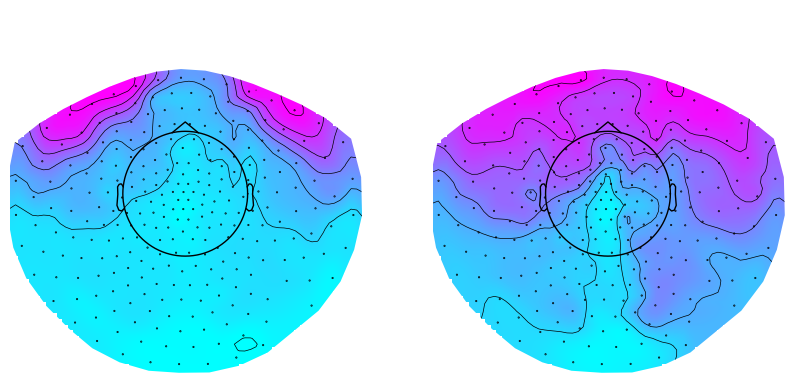

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

meg_indices = mne.pick_types(epochs.info, meg=True, ref_meg=False)

f, ax = plt.subplots(1, 2, figsize=(10,5))

mne.viz.plot_topomap(acw50[meg_indices], mne.pick_info(epochs.info, sel=meg_indices), axes=ax[0], show=False, cmap=mpl.cm.cool)
mne.viz.plot_topomap(tau[meg_indices], mne.pick_info(epochs.info, sel=meg_indices), axes=ax[1], show=False, cmap=mpl.cm.cool)

f.show()

## Where to go next?

If you are curious about further usage of IntrinsicTimescales.jl, check out the documentation [here](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/home/). In the documentation, you can see the [Practice](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/practice/practice_intro/) section which builds up the intuition for calculating INTs from very basic building blocks. Using IntrinsicTimescales.jl with Fieldtrip is covered [here](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/tutorial/tutorial_3_ft/). Finally, in both practice section, and [here](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/simbasedinference/) you can find details on state-of-the-art Bayesian methods to estimate timescales. 